# Clustering images

As well as abstract data parameters such as created by the `make_blobs()` function and physical measurements as seen in the iris exercise, clustering can also be used on images.

The classic use for this is to reduce the number of colours used in an image for either compression or artistic purposes.

As with most machine learning algorithms working on images, the first step is to understand how an image is represented on a computer and to convert that into a format that the algorithm can understand.

In it simplest form, an image is represented as a 3-dimensional array of numbers. Two of those dimensions represent the width and height of the image and the third is the _colour dimension_. The colour dimension usually only has three values in it, one for how green that pixel is, one for how red it is and one for how blue it is. Each of these values will usually be an integer between 0 and 255 (one byte per colour channel).

This means that a colour image which is 15 pixels wide and 10 pixels high will have $15 \times 10 \times 3 = 450$ numbers used to describe it.

Let's start by loading a photo from the internet using scikit-image's `imread()` function.

Looking at the shape we see that it is 480 pixels square and it has 3 colour chanels.

In [1]:
from skimage import io

photo = io.imread("https://upload.wikimedia.org/wikipedia/commons/thumb/9/97/Swallow-tailed_bee-eater_%28Merops_hirundineus_chrysolaimus%29.jpg/480px-Swallow-tailed_bee-eater_%28Merops_hirundineus_chrysolaimus%29.jpg")

print("Shape is", photo.shape)
print("Size is", photo.size)

Shape is (480, 480, 3)
Size is 691200


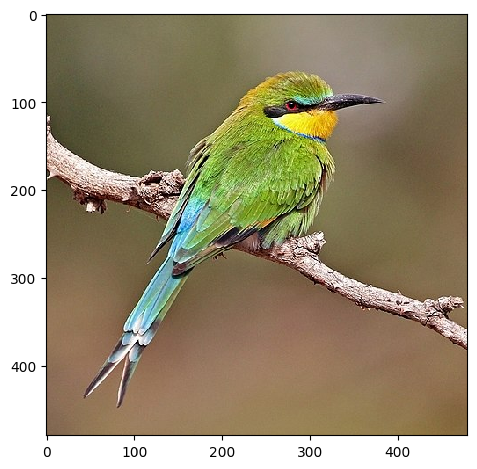

In [2]:
%matplotlib inline
io.imshow(photo)

([Swallow-tailed bee-eater by Charles J Sharp, CC BY-SA 4.0](https://commons.wikimedia.org/w/index.php?curid=55652042))

It's often more useful for machine learning to scale the values of the image to be between $0$ and $1$ rather than $0$ and $255$.

Also, for the purpose of clustering the colours in an image, we don't care what positions the pixels have, only their values. To this end, we flatten the (480, 480, 3) 3D array into a 2D array of shape (480 × 480, 3) = (691200, 3)

In [3]:
import numpy as np

photo = np.array(photo, dtype=np.float64) / 255  # Scale values
w, h, d = original_shape = tuple(photo.shape)  # Get the current shape
image_array = np.reshape(photo, (w * h, d))  # Reshape to to 2D

Now that we have our 2D image array, we put it into a pandas `DataFrame` for easier plotting and processing:

In [4]:
from pandas import DataFrame

pixels = DataFrame(image_array, columns=["Red", "Green", "Blue"])

### Exercise

- Using `pixels`, find the pixel with the highest blue value (tip: use `idxmax()`)
- Can you work out its original (x, y) position in the photo? (tip: use `//` and `%`) [<small>answer</small>](answer_find_bluest_pixel.ipynb)

## Exploring the pixel data

Before applying the clustering algorithm to the data, it's useful to plot the data.

Since RGB pixels are a 3D dataset, we will plot three, 2D plots of the pairs red/green, red/blue and green/blue. To make the plots visually useful we will also colour each point in the plot with the colour of the pixel it came from.

We create a new column which contains a label which matplotlib will be able to understand to make each point the correct colour:

In [5]:
from matplotlib import colors

pixels["colour"] = [colors.to_hex(p) for p in image_array]

Since we have $480 \times 480 = 691200$ pixels, both plotting the data and running the algorithm may be quite slow. To speed things up, we will run the algorithm fit over a random subset of the data. Pandas provides a method for doing just this, [`sample()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html). We tell it what fraction of the data we want to look at, here we specify 5%.

In [6]:
pixels_sample = pixels.sample(frac=0.05)

To make out lives easier, we define a function `plot_colours()` which will plot the three pairs of columns against each other

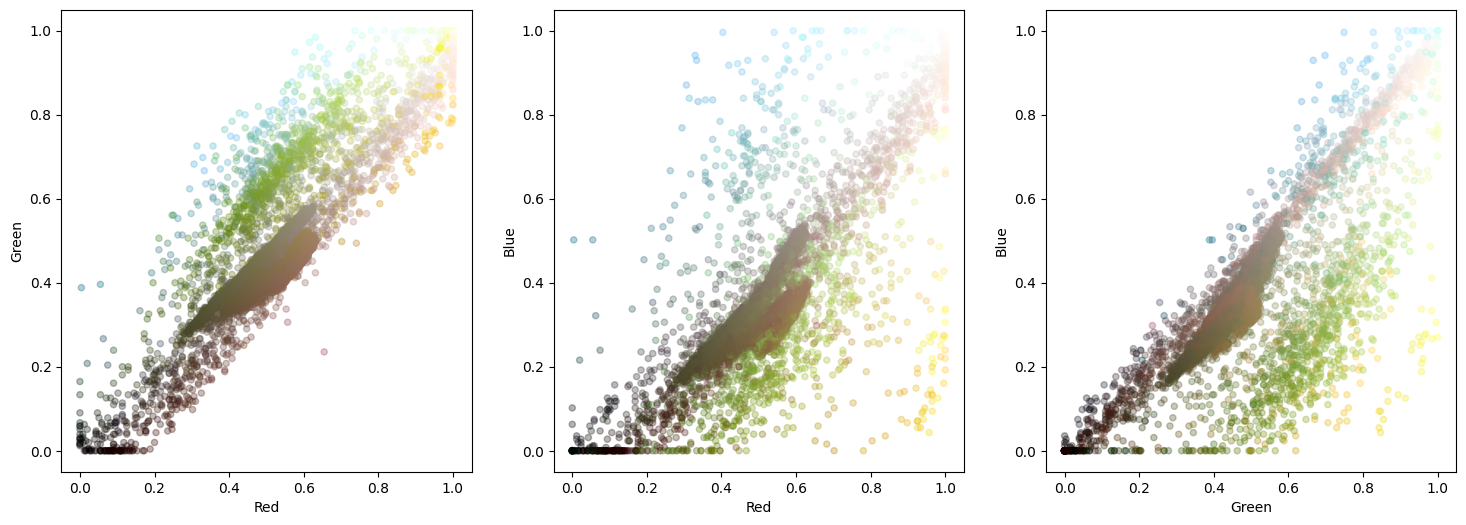

In [7]:
import matplotlib.pyplot as plt


def plot_colours(df, c1, c2, c3):
    """
    Given a DataFrame and three column names,
    plot the pairs against each other
    """
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(18, 6)
    df.plot.scatter(c1, c2, c=df["colour"], alpha=0.3, ax=ax[0])
    df.plot.scatter(c1, c3, c=df["colour"], alpha=0.3, ax=ax[1])
    df.plot.scatter(c2, c3, c=df["colour"], alpha=0.3, ax=ax[2])


plot_colours(pixels_sample, "Red", "Green", "Blue")

We see here that there is a strong brown line through the middle caused by the background with the colourful bird feathers are around the edge. In general, k-means clustering struggles to cope well with elongated features like this so we may need a larger number of clusters in order to pick out all the colours we want.

Sometimes viewing the data in 3D can help since planar projections can lose some nuances of the data. Display 3D plots using the mplot3d package.

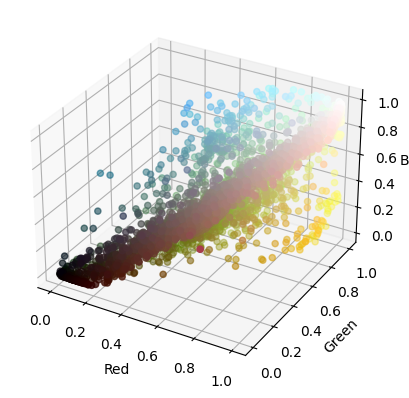

In [8]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel("Red")
ax.set_ylabel("Green")
ax.set_zlabel("Blue")
ax.scatter(pixels_sample["Red"], pixels_sample["Green"], pixels_sample["Blue"], c=pixels_sample["colour"])

You can make the 3D plot (and any other in fact) interactive by putting `%matplotlib notebook` at the top of the cell. This makes the change globally so make sure that you then have another cell which does `%matplotlib inline` to reset it back to the default static style.

In [9]:
%matplotlib inline

### Exercise

- Calculate the correlation between then red, green and blue channels. Does it match what you see in the plots? Do you think you want strong or weak correlation between your data variables? [<small>answer</small>](answer_pixel_correlation.ipynb)

Now we get on to the actual work of running the clustering. We do it in the same way as before by first specifying the number of clusters and then passing it the data.

We need to specify that the data is `pixels_sample[["Red", "Green", "Blue"]]` in order to pick out just those three columns as you should remember that we added in a fourth column containing the encoded colour string.

In [10]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, n_init="auto").fit(pixels_sample[["Red", "Green", "Blue"]])

Finally, we display the chosen cluster centres which we shall use as our representative colours for the image:

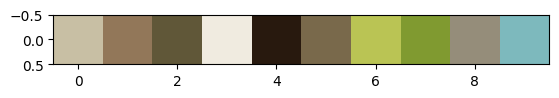

In [11]:
plt.imshow([kmeans.cluster_centers_])

## Assigning points to clusters

Once we have calculated the midpoints of each of the clusters, we can then go back through the points in the original data set and assign each point to the cluster centre it is nearest to.

In the dummy examples from the previous section we could just use the `labels_` data attribute on the model to do this but since we've only fit the data over a subset of the full data set, the `labels_` attribute will similarly only contain those data points.

The `KMeans` model provides a `predict()` method which, given the calculated cluster centres can assign a cluster to each data point passed in. This allows you to use k-means clutering as a predictive classification tool.

In [12]:
labels = kmeans.predict(pixels[["Red", "Green", "Blue"]])
labels

array([5, 2, 2, ..., 5, 5, 5], dtype=int32)

### Exercise (optional)

- Plot a bar graph of the counts of the number of pixels in each cluster. Try to colour each bar by the colour of the cluster centre. [<small>answer</small>](answer_cluster_bars.ipynb)

Given our list of `labels` we then loop though it, replacing each cluster index with the values from the corresponding cluster centre. We then reshape the array to make it 3D again (width × height × colour channels).

In [13]:
reduced = np.array([kmeans.cluster_centers_[p] for p in labels]).reshape(original_shape)

We can then plot the reduced image against the original to see the differences.

Text(0.5, 1.0, 'RGB clustered')

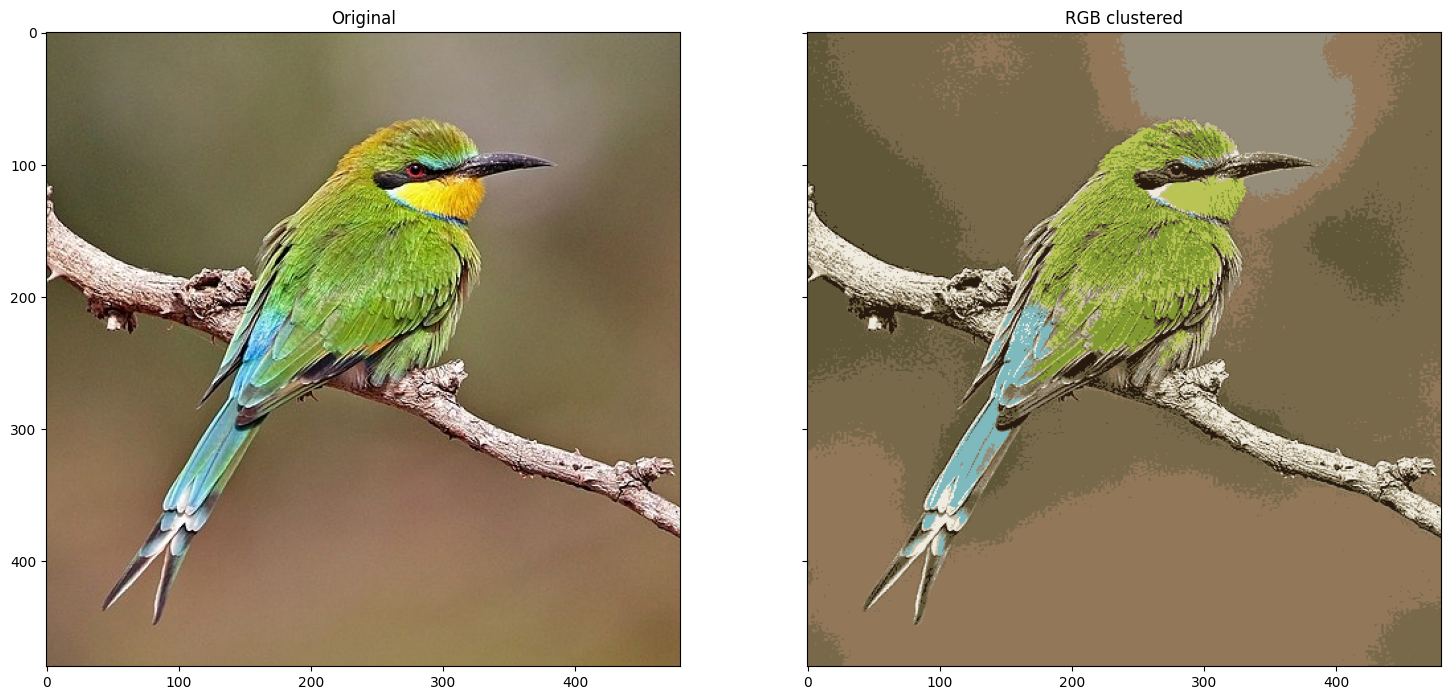

In [14]:
f, axarr = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(18, 9))
axarr[0].imshow(photo)
axarr[0].set_title("Original")
axarr[1].imshow(reduced)
axarr[1].set_title("RGB clustered")

You'll see here that it's managed to pick out some of the larger blocks of colour but the majority of the image is still brown.

There are three main ways we can immediately try to improve this:
 
1. Increase the number of clusters the algorithm is fitting
2. Transform the data to reduce the elongated nature of the clusters
3. Try a different clustering algorithm (https://scikit-learn.org/stable/modules/clustering.html)

We're going to go ahead with method 2 but feel free to play around with changing the number of clusters. Maybe even try plotting the inertia graph like we did in the last section.

## Different colour space

So far we've treated each pixel in the images as being defined by their RGB value, that is their total amount of red, green and blue in each pixel. This is not the only way to describe the colour of a pixel and over the decades, different schemes have emerged. RGB is popular and useful as it is the closes to how a computer monitor or phone screen works where physical red, green and blue lights create the picture.

The next most commonly used colour space is probably HSV where the three numbers represent the hue (like on a colour wheel), saturation (the scale from grey to bright) and value (the scale from black to colourful).

For the purposes of separating out the visual colour space, there is another colour space called [L\*a\*b\*](https://en.wikipedia.org/wiki/CIELAB_color_space) (often just referred to as _Lab_) which expresses colour as three numerical values, _L\*_ for the lightness and _a\*_ and _b\*_ for the green–red and blue–yellow colour components respectively. Unlike RGB, it is designed to better represent human vision and gives a more uniform representation of brightness.

Due to how it arranges colours, a plot of a\* against b\* will often give a useful spread of colours and is probably most likely to show clusters.

scikit-image provides [functions for converting images between different colour spaces](http://scikit-image.org/docs/dev/api/skimage.color.html), including `rgb2lab()` and `lab2rgb()`.

Let's go through the same steps as before, the only difference being that we start by passing the image though the `rgb2lab()` function:

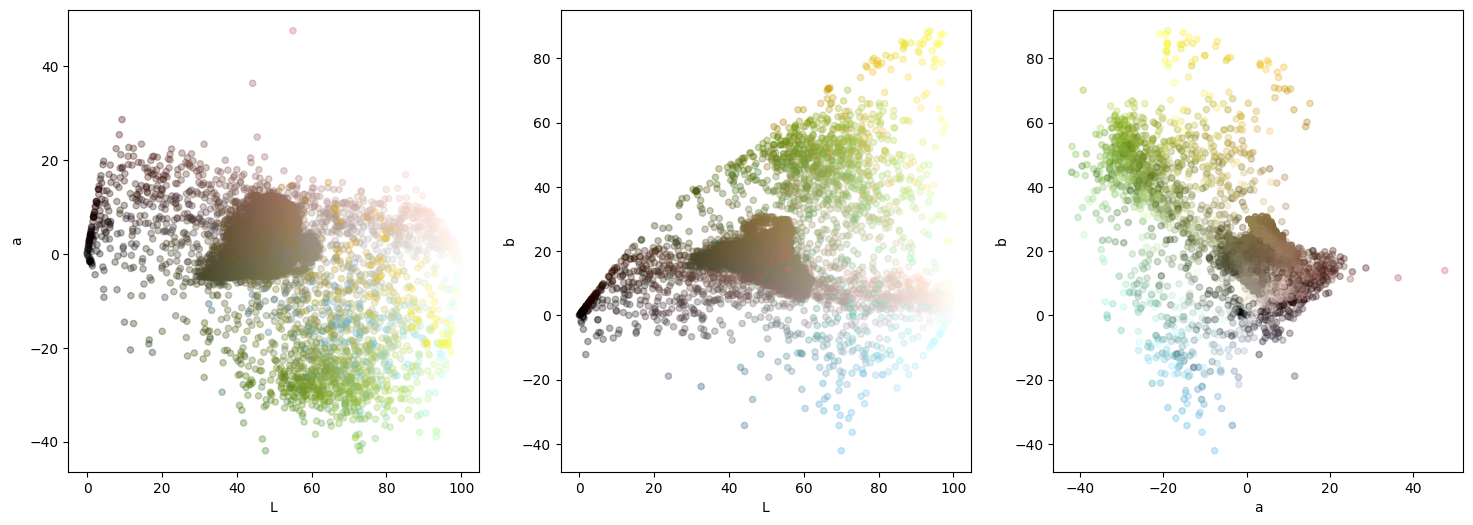

In [15]:
from skimage.color import rgb2lab, lab2rgb

photo_lab = rgb2lab(photo)  # This is where we convert colour space
w, h, d = original_shape = tuple(photo_lab.shape)
image_array_lab = np.reshape(photo_lab, (w * h, d))

pixels_lab = DataFrame(image_array_lab, columns=["L", "a", "b"])

pixels_lab["colour"] = [colors.to_hex(p) for p in image_array]
pixels_sample_lab = pixels_lab.sample(frac=0.05)

plot_colours(pixels_sample_lab, "L", "a", "b")

Immediately we see a difference from when we did this plot with RGB. We no longer have the strong diagonal line though the image (though there is still a prominent horizontal line). Looking in the third plot, (a\* against b*) we can see distinctly the blue, green and yellow areas.

Passing this converted data set to `KMeans` gives us our new set of cluster centres which we can view by converting them back from L\*a\*b\* to RGB.

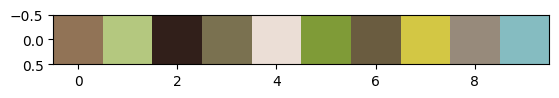

In [16]:
kmeans_lab = KMeans(n_clusters=10, n_init="auto").fit(pixels_sample_lab[["L", "a", "b"]])
plt.imshow(lab2rgb([kmeans_lab.cluster_centers_]))

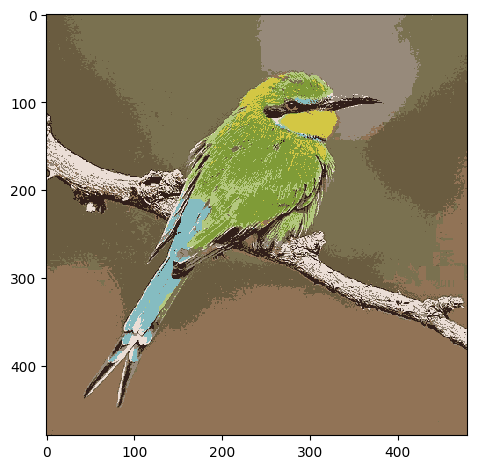

In [17]:
labels_lab = kmeans_lab.predict(pixels_lab[["L", "a", "b"]])  # Assign pixels to the cluster centre
centers_lab = lab2rgb([kmeans_lab.cluster_centers_])[0]  # Get the RGB of the cluster centres
reduced_lab = np.array([centers_lab[p] for p in labels_lab]).reshape(original_shape)  # Map and reshape
io.imshow(reduced_lab)

## Comparing the results

Now that we have run the analysis with the raw data and the transformed data, we should compare the outcomes.

Text(0.5, 1.0, 'Lab clustered')

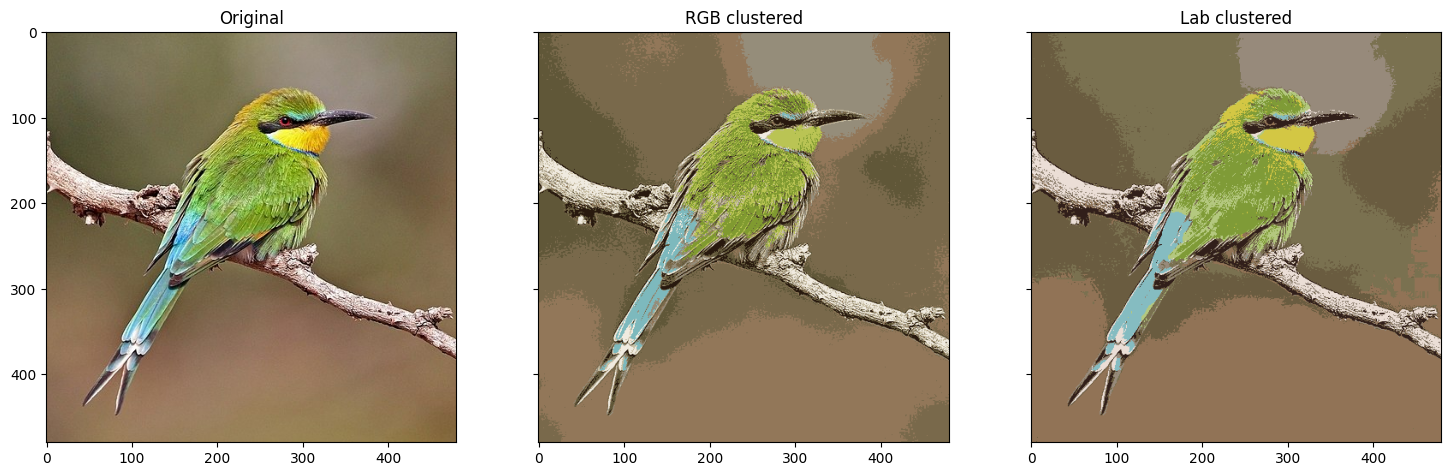

In [18]:
f, axarr = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(18, 6))
axarr[0].imshow(photo)
axarr[0].set_title("Original")
axarr[1].imshow(reduced)
axarr[1].set_title("RGB clustered")
axarr[2].imshow(reduced_lab)
axarr[2].set_title("Lab clustered")

Plotting the three next to each other, we see some differences. The L\*a\*b\* data seems to have picked out more of the different colours of the bird at the expense of some of the brown shades.

It is possible that another colour space or a different transform may perform better but under the limit of 10 clusters, it seems that L\*a\*b\* performs a little better.

### Exercise

- Experiment with different numbers of clusters. Is there a point where the two colour space methods become indistinguishable?
- Plot on the same graph the inertia against number of clusters for the two colour spaces. Does one drop faster than the other? (tip: you may need to normalise them against each other) [<small>answer</small>](answer_colour_space_inertia.ipynb)
- Try the process with another image. Try to keep the image small (~500 pixels in each dimension) or reduce the `frac` when `sample()`ing.
- Try adding in the HSV or HSL colour spaces or any others that scikit-image supports.

That's all of the exercises for today. Move on to the next section for some pointers on what you may want to look into next and some book recomendations.